In [1]:
import collections
import random

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Tensorflow
import tensorflow as tf

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

### Load the data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


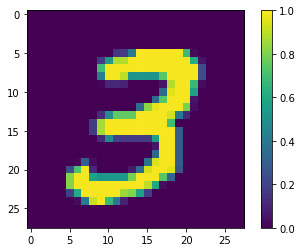

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### Downscale the images

In [6]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


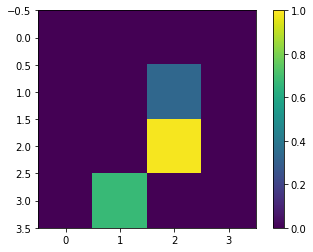

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### Remove contradicting examples

In [8]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
        mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
        labels = mapping[tuple(x.flatten())]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(labels.pop())
        else:
            # Throw out images that match more than one label.
            pass

    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [9]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  49
Number of 6s:  49
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  10338


In [10]:
# Flatten
x_train_flatten = [tf.reshape(x, [-1]) for x in x_train_nocon]
x_test_flatten = [tf.reshape(x, [-1]) for x in x_test_small]

# Convert to tensor again
x_train_flatten = tf.convert_to_tensor(x_train_flatten)
x_test_flatten = tf.convert_to_tensor(x_test_flatten)

### Setting some parameters to the circuit

In [11]:
n_qubits = 16
n_quantum_layers = 2
batch_size = 4
epochs = 1

In [12]:
dev = qml.device("default.qubit", wires=n_qubits)

### Random selection of quantum gates

In [13]:
def set_random_gates(n_qubits: int):
    
    gate_set = [qml.RX, qml.RY, qml.RZ]
    chosen_gates = []
    for i in range(n_qubits):
        chosen_gate = random.choice(gate_set)
        chosen_gates.append(chosen_gate)
    return chosen_gates

### Quantum net

We first define some quantum layers that will compose the quantum circuit.

In [14]:
def apply_layer(gates, weights):
    """Docstrings"""
    
    for i in range(n_qubits): 
        gates[i](weights[i], wires = i)
    
    tuples = [(i,i+1) for i in range(n_qubits-1)]

    for tup in tuples:
        qml.CZ(wires=[tup[0], tup[1]])

In [15]:
@qml.qnode(dev)
def quantum_net(inputs, layer_weights):
    """Docstrings"""
        
    wirelist = [i for i in range(n_qubits)]
    
    #Encode the data with Angle Embedding
    qml.templates.AngleEmbedding(inputs, wires=wirelist, rotation='X')
    
    # Sequence of trainable layers
    for i in range(len(layer_gates)):
        apply_layer(layer_gates[i], layer_weights[i]) #maybe "weights" needs a reformat
        
    # Expectation value of the last qubit
    return qml.expval(qml.PauliZ(n_qubits-1))

### Interface with Tensorflow architecture

In [16]:
# Obtain random gates for each layer
layer_gates = [set_random_gates(n_qubits) for i in range(n_quantum_layers)]

# Define shape of the weights
weight_shapes = {"layer_weights": (n_quantum_layers, n_qubits)}

In [17]:
qlayer = qml.qnn.KerasLayer(quantum_net, weight_shapes, output_dim=1)
model = tf.keras.models.Sequential([qlayer])

In [18]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [19]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [20]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

### Train the model

In [21]:
# Test with less examples
x_train_flatten = x_train_flatten[:500]
y_train_hinge = y_train_hinge[:500]

In [22]:
qnn_history = model.fit(
      x_train_flatten, y_train_hinge,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_data=(x_test_flatten, y_test_hinge))

qnn_results = model.evaluate(x_test_flatten, y_test)

 44/125 [=========>....................] - ETA: 29:42 - loss: 1.1248 - hinge_accuracy: 0.4375

KeyboardInterrupt: 